## CNN model on Surface Cracks




21BDA26

In [3]:
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np

ModuleNotFoundError: No module named 'keras'

In [2]:
# labels = ['Negative', 'Positive']
# img_size = 128
# def read_images(data_dir):
#     data = [] 
#     
#     for label in labels: 
#         path = os.path.join(data_dir, label)
#         class_num = labels.index(label)
#         count = 5000
#         for img in os.listdir(path):
#             img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
#             resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
#             data.append([resized_arr, class_num])
#             count-=1;
#             if count==0:
#                 break
#     return np.array(data)

In [3]:
labels = ['Negative', 'Positive']
img_size = 128
def read_images(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
            data.append([resized_arr, class_num])
            
    return np.array(data)

In [4]:
Dataset = read_images('../input/surface-crack-detection')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [5]:
from sklearn.model_selection import train_test_split

x = []
y = []

for feature, label in Dataset:
    x.append(feature)
    y.append(label)

x = np.array(x).reshape(-1, img_size, img_size, 1)
x = x / 255
y = np.array(y)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=8)

In [7]:
import gc
del x,y
gc.collect()

68

## CNN

In [8]:
model = Sequential()

model.add(Conv2D(2,3,padding="same", activation="relu", input_shape = X_train.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(4,3,padding="same", activation="relu", input_shape = X_train.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(8,3,padding="same", activation="relu", input_shape = X_train.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(16,3,padding="same", activation="relu", input_shape = X_train.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(32,3,padding="same", activation="relu", input_shape = X_train.shape[1:]))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

# model.add(Conv2D(256, 3, padding="same", activation="relu"))
# model.add(MaxPool2D())


model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.01))
model.add(BatchNormalization())
model.add(Dense(2, activation="softmax"))

model.summary()

2022-05-12 00:27:14.618387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 2)       20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 4)         76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        1

2022-05-12 00:27:14.722302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 00:27:14.723085: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 00:27:14.724212: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-12 00:27:14.724561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [9]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score


class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(
            self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        return

metrics = Metrics()

In [10]:
len(X_train)

30000

In [11]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss="sparse_categorical_crossentropy",metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs = 400, 
                    batch_size = 256, 
                    validation_data = (X_test, y_test), 
                    verbose=1)

2022-05-12 00:27:18.262054: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1966080000 exceeds 10% of free system memory.
2022-05-12 00:27:20.340880: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1966080000 exceeds 10% of free system memory.
2022-05-12 00:27:21.778016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/400


2022-05-12 00:27:23.375522: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


118/118 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9597

2022-05-12 00:27:32.639350: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 655360000 exceeds 10% of free system memory.
2022-05-12 00:27:33.298562: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 655360000 exceeds 10% of free system memory.


118/118 [==============================] - 13s 42ms/step - loss: 0.1251 - accuracy: 0.9597 - val_loss: 0.5352 - val_accuracy: 0.5059
Epoch 2/400
118/118 [==============================] - 3s 24ms/step - loss: 0.0369 - accuracy: 0.9882 - val_loss: 0.1322 - val_accuracy: 0.9863
Epoch 3/400
118/118 [==============================] - 3s 24ms/step - loss: 0.0307 - accuracy: 0.9904 - val_loss: 0.0706 - val_accuracy: 0.9909
Epoch 4/400
118/118 [==============================] - 3s 25ms/step - loss: 0.0261 - accuracy: 0.9917 - val_loss: 0.0377 - val_accuracy: 0.9923
Epoch 5/400
118/118 [==============================] - 3s 24ms/step - loss: 0.0233 - accuracy: 0.9922 - val_loss: 0.0283 - val_accuracy: 0.9899
Epoch 6/400
118/118 [==============================] - 3s 24ms/step - loss: 0.0200 - accuracy: 0.9934 - val_loss: 0.0184 - val_accuracy: 0.9945
Epoch 7/400
118/118 [==============================] - 3s 24ms/step - loss: 0.0186 - accuracy: 0.9939 - val_loss: 0.0691 - val_accuracy: 0.9748
Epo

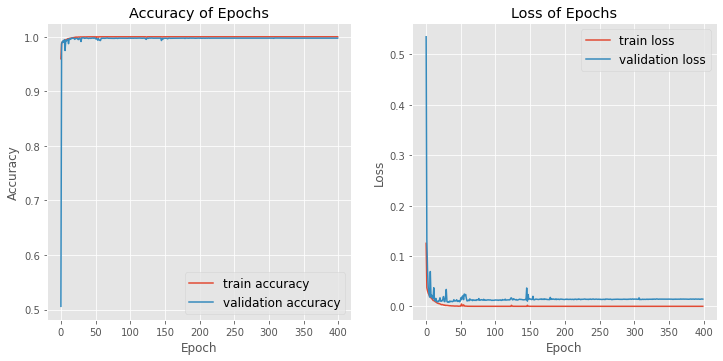

In [12]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of Epochs')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of Epochs')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

In [1]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict(X_test)
tp=0
fp=0
tn=0
fn=0
for i in range(len(predictions)):
    if (predictions[i][0]>=predictions[i][1]):
        if y_test[i] == 0:
            tn += 1
        else:
            fn += 1
    else:
        if y_test[i] == 1:
            tp += 1
        else:
            fp += 1
print(tp,fp,tn,fn)
            
acur = (tp + tn)/(tp+tn+fp+fn) * 100
pre = tp / (tp+fp) * 100
recall = tp / (tp+fn) * 100
f1 = (2*pre*recall)/(pre+recall)
print('Accuracy: ',acur,'\n','Precission: ',pre,'\n','Recall:',recall,'\n','F1 Score: ',f1)

NameError: name 'model' is not defined

In [14]:
X_train.shape[1:]

(128, 128, 1)